# IMDB Example

This example is based on an example from François Chollet's Deep Learning
with Python that was also made available in the
`3.5-classifying-movie-reviews.ipynb` notebook at

    https://github.com/fchollet/deep-learning-with-python-notebooks

In [ ]:
!cd .. && pip install -e .

In [1]:
from keras import layers, models
from keras.datasets import imdb
from keras.layers import Dense
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop
from keras.utils import to_categorical

import numpy as np

from pybt import Trainer
from pybt.model import KerasModelWrapper
from pybt.policy.ready import ReadyAfter
from pybt.policy.done import StopAfter

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))

    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.

    return results

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

model = models.Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=0.001),
              loss=binary_crossentropy,
              metrics=['accuracy'])

In [54]:
# Create a population with this model and train
m = KerasModelWrapper(model, optimizer=RMSprop(lr=0.001),
                      loss=binary_crossentropy,
                      metrics=['accuracy'])
t = Trainer(model=m,
    stopping_criteria=StopAfter(epochs=20),
    ready_strategy=ReadyAfter(4),
    step_args={'epochs_per_step': 2,
               'fit_args': {
                   'x': partial_x_train, 'y': partial_y_train,
                   'validation_data': (x_val, y_val),
                   'batch_size': 512}},
    eval_args={'x': x_val, 'y': y_val})
model, score = t.train()

10000/10000 [==============================] - 1s 119us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/2
15000/15000 [==============================] - 2s 118us/step - loss: 0.1392 - acc: 0.9534 - val_loss: 0.2968 - val_acc: 0.8833
Epoch 2/2
10000/10000 [==============================] - 1s 121us/step
Train on 15000 samples, validate on 10000 samples
Epoch 3/4
15000/15000 [==============================] - 2s 118us/step - loss: 0.0975 - acc: 0.9668 - val_loss: 0.3333 - val_acc: 0.8794
Epoch 4/4
10000/10000 [==============================] - 1s 124us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/2
15000/15000 [==============================] - 5s 328us/step - loss: 0.2693 - acc: 0.8946 - val_loss: 0.2862 - val_acc: 0.8855
Epoch 2/2
10000/10000 [==============================] - 1s 127us/step
Train on 15000 samples, validate on 10000 samples
Epoch 3/4
15000/15000 [==============================] - 5s 333us/step - loss: 0.1290 - acc: 0.9531 - val_loss: 0.3

10000/10000 [==============================] - 2s 151us/step
Train on 15000 samples, validate on 10000 samples
Epoch 7/8
15000/15000 [==============================] - 6s 372us/step - loss: 0.1215 - acc: 0.9665 - val_loss: 0.2759 - val_acc: 0.8913
Epoch 8/8
10000/10000 [==============================] - 2s 151us/step
Train on 15000 samples, validate on 10000 samples
Epoch 9/10
15000/15000 [==============================] - 6s 384us/step - loss: 0.1211 - acc: 0.9667 - val_loss: 0.2760 - val_acc: 0.8914
Epoch 10/10
10000/10000 [==============================] - 2s 191us/step
Train on 15000 samples, validate on 10000 samples
Epoch 11/12
15000/15000 [==============================] - 7s 446us/step - loss: 0.1207 - acc: 0.9668 - val_loss: 0.2760 - val_acc: 0.8916
Epoch 12/12
10000/10000 [==============================] - 2s 157us/step
Train on 15000 samples, validate on 10000 samples
Epoch 13/14
15000/15000 [==============================] - 6s 385us/step - loss: 0.1203 - acc: 0.9667 - val_

## Plotting population results

In [65]:
import matplotlib.pyplot as plt

obs = t.observations()

In [123]:
def learning_rates(obs):
    epoch, lr = ([], [])
    
    for m in obs:
        for o in m['observations']:
            epoch.extend(o['epochs'])
            lr.extend(o['learning_rate'])
    
    return epoch, lr

def member_observations(obs, index):
    step, epoch, acc, loss, val_acc, val_loss = ([], [], [], [], [], [])
    
    member = obs[index]
    
    for x in member['observations']:
        step.extend([x['t'] for i in range(len(x['epochs']))])
        epoch.extend(x['epochs'])
        acc.extend(x['acc'])
        loss.extend(x['loss'])
        val_acc.extend(x['val_acc'])
        val_loss.extend(x['val_loss'])

    return step, epoch, acc, loss, val_acc, val_loss

def plot_members_acc(obs):
    for i in range(len(obs)):
        step, epoch, acc, loss, val_acc, val_loss = member_observations(obs, i)

        plt.plot(epoch, acc, 'bo', label='Training acc.')
        plt.plot(epoch, val_acc, 'b', label='Validation acc.')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training acc.', 'Validation acc.'])
    
    return plt

def plot_all_acc(obs, nrow=None, ncol=3):
    num_members = len(obs)
    
    if nrow == None and ncol == None:
        raise ValueError('at least one of `nrow` and `ncol` must be set')

    if nrow == None:
        nrow = num_members // ncol + (num_members % ncol != 0)
    elif ncol == None:
        ncol = num_members // nrow + (num_members % nrow != 0)

    if num_members > nrow * ncol:
        raise RuntimeError('cannot fit {} plots in {} panels'.format(
            num_members, nrow*ncol))
    
    plt.close('all')

    fig, panels = plt.subplots(nrows=nrow, ncols=ncol, sharex=True, sharey=True)
    fig.set_figheight(30)
    fig.set_figwidth(30)
    
    m_id = 0
    for i in range(nrow):
        for j in range(ncol):
            if m_id < num_members:
                panel = panels[i,j]
                plot_member_panel_acc(panel, obs, m_id)
                m_id += 1
    
    plt.tight_layout()

def plot_member_panel_acc(panel, obs, index):
    step, epoch, acc, loss, val_acc, val_loss = member_observations(obs, index)
    
    panel.text(18, .9, 'm{}'.format(index), fontsize=24)
    panel.plot(epoch, acc, 'bo', label='Training acc.')
    panel.plot(epoch, val_acc, 'b', label='Validation acc.')
    
    #plt.xlabel('Epochs')
    #plt.ylabel('Accuracy')
    #plt.legend()
    
def plot_member_acc(obs, index):
    step, epoch, acc, loss, val_acc, val_loss = member_observations(obs, index)

    plt.plot(epoch, acc, 'bo', label='Training acc.')
    plt.plot(epoch, val_acc, 'b', label='Validation acc.')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    return plt

def plot_member_loss(obs, index):
    step, epoch, acc, loss, val_acc, val_loss = member_observations(obs, index)

    plt.plot(epoch, loss, 'bo', label='Training loss')
    plt.plot(epoch, val_loss, 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    return plt

def plot_learning_rate(obs):
    epoch, lr = learning_rates(obs)
    
    plt.scatter(epoch, lr)
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    
    return plt

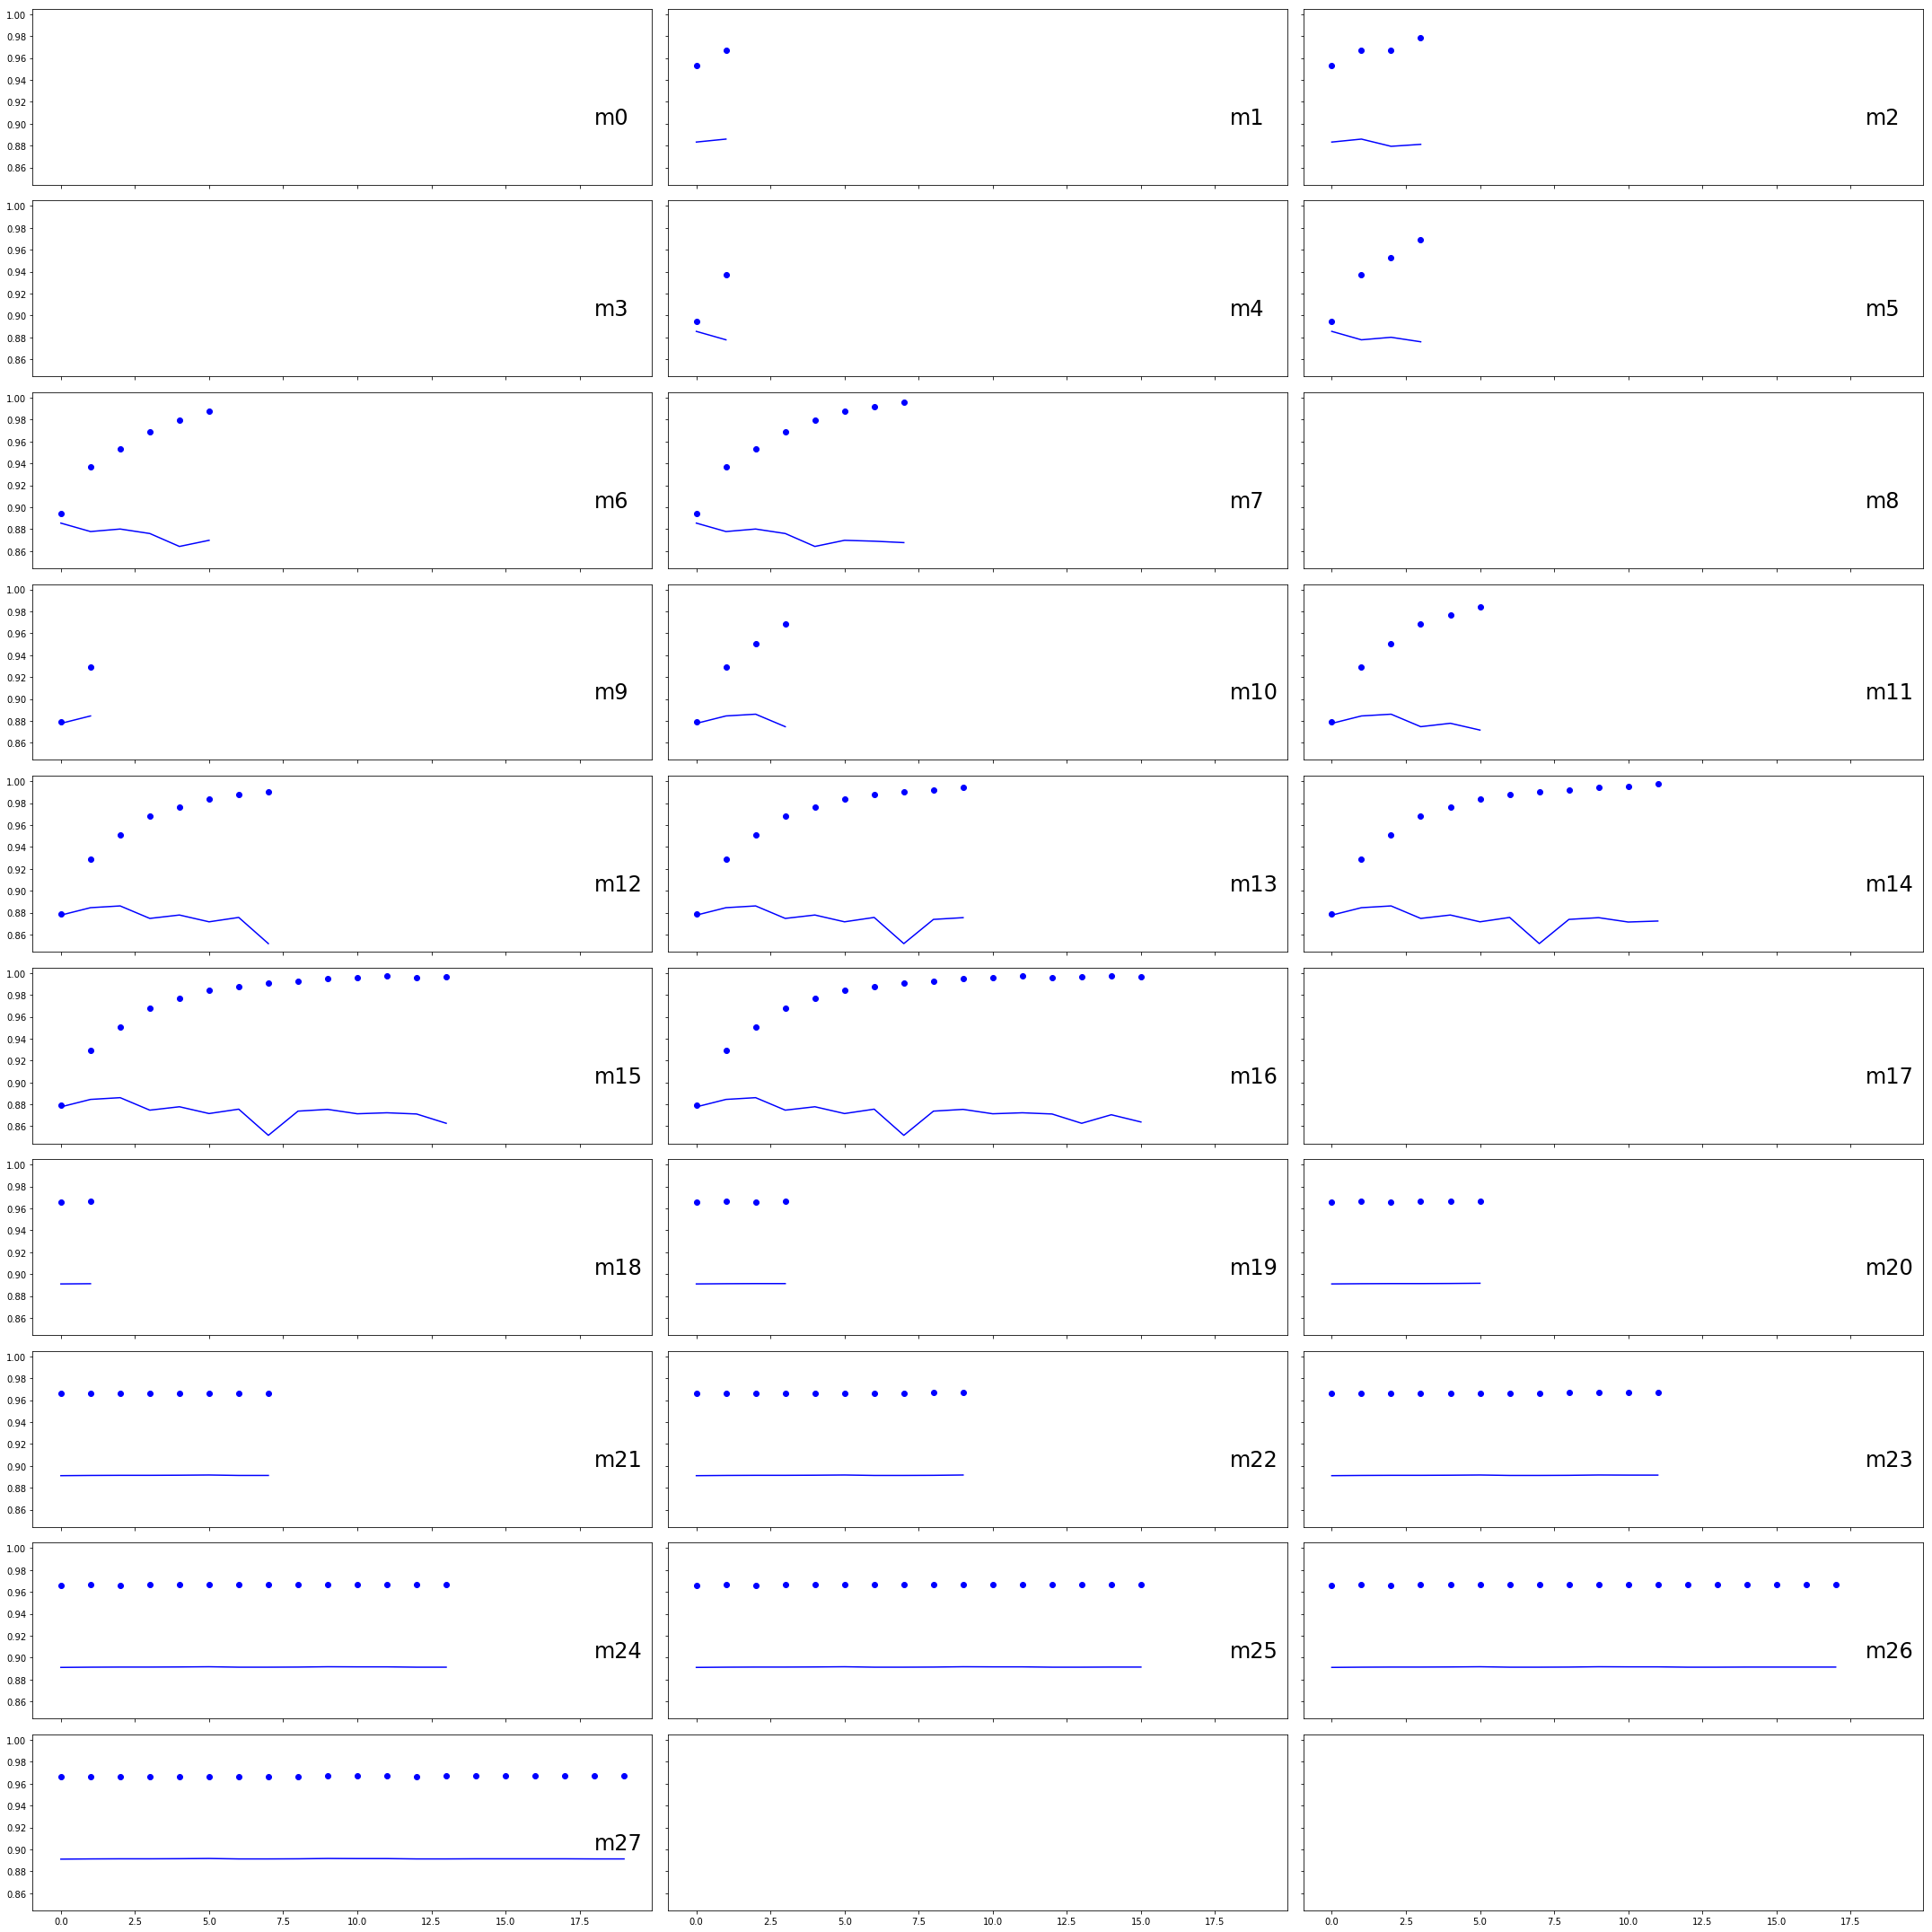

In [122]:
plot_all_acc(obs)

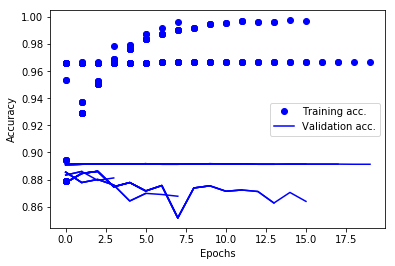

In [66]:
plot_members_acc(obs).show()

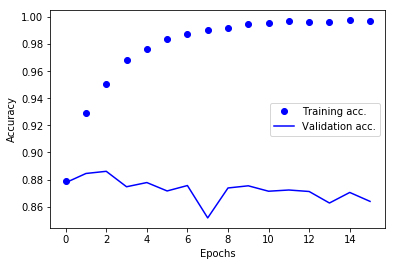

In [125]:
plot_member_acc(obs, 16).show()

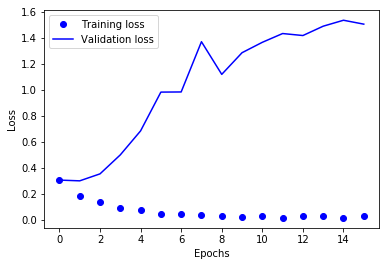

In [126]:
plot_member_loss(obs, 16).show()

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

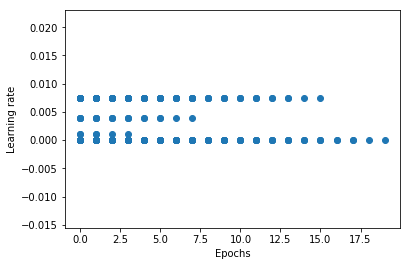

In [124]:
plot_learning_rate(obs)